In [1]:
import os 
from ipsl_dataset import IPSL_DCPP
import lightning.pytorch as pl
import torch
import hydra
from ipsl_dataset import surface_variables
scratch = os.environ['SCRATCH']
work = os.environ['WORK']
run_name = ''
#checkpoint_path = f'{scratch}/{run_name}_epoch=299.ckpt'
checkpoint_path = f'{work}/ipsl_dcpp/ipsl_dcpp_emulation/6l0y0nym/checkpoints/epoch=4-step=14125.ckpt'

In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf


with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")


In [6]:
checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
test = IPSL_DCPP('test',6)
test_dataloader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False,num_workers=1)
model = hydra.utils.instantiate(cfg.experiment.module,backbone=hydra.utils.instantiate(cfg.experiment.backbone),dataset=test_dataloader.dataset)

model.load_state_dict(checkpoint['state_dict'])


/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [7]:
trainer = pl.Trainer(limit_predict_batches=0.005)
output = trainer.predict(model, test_dataloader)
# 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
SLURM auto-requeueing enabled. Setting signal handlers.
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bo

Predicting DataLoader 0: 100%|██████████| 28/28 [02:54<00:00,  0.16it/s]


In [8]:
def get_time_series(output,var_index):
    pred_means = []
    batch_means = []
    for i in range(len(output)):
        pred = output[i][0]
        batch = output[i][1]
        pred_means.append(pred['next_state_surface'][0][var_index].mean().item())
        batch_means.append(batch['next_state_surface'][0][var_index].mean().item())
    return pred_means,batch_means

Text(0.5, 1.0, 'global mean of gpp')

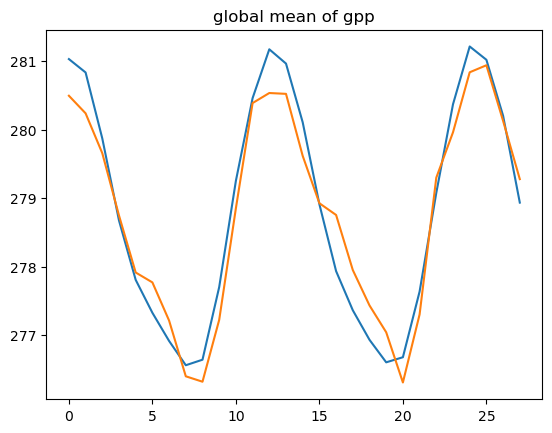

In [9]:
import matplotlib.pyplot as plt
ps,bs = get_time_series(output,surface_variables.index('tas'))
plt.plot(ps)
plt.plot(bs)
plt.title('global mean of gpp')
#DOCUMENT THESE RESULTS METHODICALLY 


In [8]:
import xarray as xr
ds = xr.open_dataset(test.files[0])
shell = ds.isel(time=0)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

for var in surface_variables:
    var_index = surface_variables.index(var)
    mae = np.abs(batch['next_state_surface'][0][var_index,:,:] - pred['next_state_surface'][0][var_index,:,:]).mean().item()
    print(var,mae)

baresoilFrac 2.8847568035125732
c3PftFrac 3.960676908493042
c4PftFrac 1.302024483680725
cLeaf 0.007261114194989204
cLitter 0.034944549202919006
cLitterAbove 0.02850738726556301
cLitterBelow 0.009802833199501038
cProduct 0.0071585578843951225
cRoot 0.047029878944158554
cSoilFast 0.003399807494133711
cSoilMedium 0.07211760431528091
cSoilSlow 0.1229531541466713
cVeg 0.2235301434993744
cropFrac 1.5729695558547974
mrsos 1.2372705936431885
evspsblsoi 1.4006535593580338e-06
evspsblveg 6.872824087622575e-07
fHarvest 2.5749025134302883e-10
fLitterSoil 4.0955810964860007e-10
fVegLitter 1.2185570330558448e-09
grassFrac 2.5335795879364014
lai 0.11879536509513855
mrfso 15.635823249816895
mrro 5.002853413316188e-06
mrros 2.883471324821585e-06
mrso 24.136722564697266
prveg 6.86908947500342e-07
rGrowth 8.262315831508715e-10
rMaint 9.802102463041251e-10
ra 1.5816261633716522e-09
rh 6.975258148855801e-10
tran 1.340307335340185e-06
treeFrac 2.6291656494140625
treeFracPrimDec 1.7162649631500244
treeFracPr

In [13]:
var_index = surface_variables.index('nep')

In [14]:
import numpy as np

Text(0.5, 1.0, 'tas')

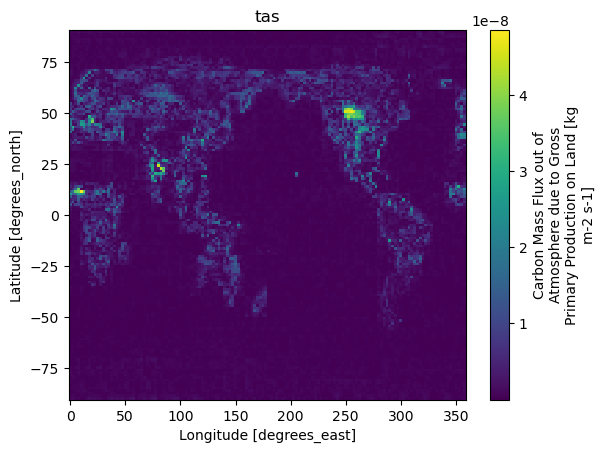

In [16]:
shell['gpp'].data = np.abs(batch['next_state_surface'][0][var_index,:,:] - pred['next_state_surface'][0][var_index,:,:])
shell['gpp'].plot.pcolormesh()
plt.title('tas')
